# Semantic Segmentation of Mars Surface Images – First Model

This notebook trains a **first-stage semantic segmentation model** to classify each pixel of grayscale Mars images into:
- **0:** Background
- **1:** Soil
- **2:** Bedrock
- **3:** Sand
- **4:** Big Rock

**Overview:**  
We begin by loading and preprocessing cleaned training data. After a stratified train/validation split, we apply augmentations to improve model robustness. The model is a U-Net variant with:
- **Gated Skip Connections:** Control feature flow from encoder to decoder.
- **Deep Supervision:** Intermediate outputs guide learning at multiple scales.

We use **focal loss** to handle class imbalances and **Mean IoU** to measure performance. Training is enhanced with learning rate reduction and early stopping callbacks. Once trained, we evaluate results, visualize training history, compute a confusion matrix, and apply morphological post-processing.

**Outcome:**  
This model provides initial segmentation predictions. These predictions can later be refined by a second model or additional techniques, forming a two-step approach to improving semantic segmentation accuracy on Martian terrain.
.


In [1]:
!pip install albumentations
!pip install segmentation-models
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-yj63zqh7
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-yj63zqh7
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=270354 sha256=885af5a15efaa8cf56e0d286cc1222f958b4828ce2fb62e91f961fbe6fcacb39
  Stored in directory: /tmp/pip-ephem-wheel-cache-akss6zqh/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


# Import libraries

In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, BatchNormalization,
                                     Activation, Add, Concatenate, GlobalAveragePooling2D, Dense, Multiply, MaxPooling2D)
import numpy as np
from sklearn.model_selection import train_test_split
from keras_cv.layers import RandomFlip, RandomRotation, RandomZoom
import tensorflow_probability as tfp
import keras_cv
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB3

import os
from datetime import datetime
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import cv2
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Segmentation Models: using `tf.keras` framework.


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Import Data

#### Dataset Details

- **Image Size:** 64x128
- **Color Space:** Grayscale (1 channel)
- **Input Shape:** (64, 128)
- **File Format:** `.npz` (Numpy archive)
- **Number of Classes:** 5

#### Class Labels

- **0:** Background
- **1:** Soil
- **2:** Bedrock
- **3:** Sand
- **4:** Big Rock

## Import cleaned train data

We used the AI-HW2-Preprocessing notebook to generate processed and cleaned data for both training and validation. The resulting files are loaded here.

For training, we use a dataset that includes augmentation(adding patches from the minor class to other images), while for validation, we use a separate dataset without augmentation.

In [4]:
# Load training data for TRAINING from first dataset
data_train_01 = np.load("/kaggle/input/dataset-01/cleaned_training_set (6).npz")
train_images_01, train_labels_01 = data_train_01['images'], data_train_01['labels']

# Load data for VALIDATION from the main unaugmented dataset
data_main = np.load("/kaggle/input/dataset-main/cleaned_training_set.npz")
train_images_main, train_labels_main = data_main['images'], data_main['labels']

train_images_01.shape, train_labels_01.shape, train_images_01.max()

((2505, 64, 128), (2505, 64, 128), 254)

## Import Test data

For testing the raw data hould be used so we are loading them from the original dataset file provided for the competition.

In [5]:
# Load and clean data from the kaggle input
data = np.load("/kaggle/input/dataset-main/mars_for_students.npz")
test = data['test_set']
image_ratio = test.shape[1] / test.shape[2]
test.shape, test.max(), data['training_set'].max()

((10022, 64, 128), 255, 254.0)

# Preprocessing

## Splitting data

Calculating class distribution

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def calculate_class_distributions(labels):
    distributions = np.array([np.bincount(label.ravel(), minlength=5) for label in labels])
    return distributions

def plot_class_distribution(labels, title):
    distributions = np.sum(calculate_class_distributions(labels), axis=0)
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(distributions)), distributions)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Pixel Count")
    plt.xticks(range(len(distributions)))
    plt.show()

# Ensure both have the same shape and order
assert train_images_01.shape == train_images_main.shape, "Mismatched shapes between dataset-01 and dataset-main images!"
assert train_labels_01.shape == train_labels_main.shape, "Mismatched shapes between dataset-01 and dataset-main labels!"

# Compute distributions on dataset-01 labels for stratification
distributions = calculate_class_distributions(train_labels_01)
dominant_class = np.argmax(distributions, axis=1)

splitting the dataset while respecting the dominnant class

X_train Shape: (2129, 64, 128)
X_valid Shape: (376, 64, 128)
y_train Shape: (2129, 64, 128)
y_valid Shape: (376, 64, 128)
Class distributions in the training set:


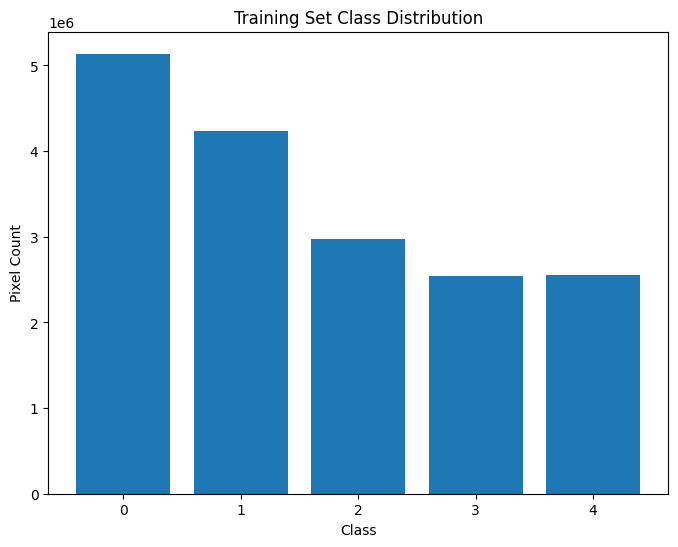

Class distributions in the validation set:


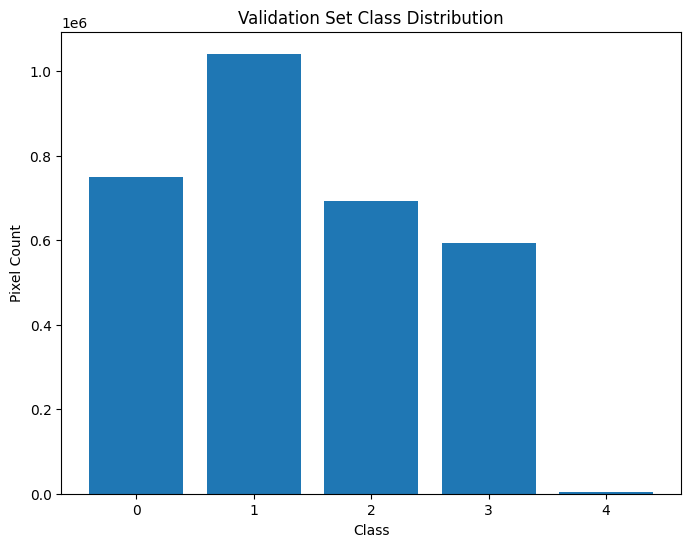

In [7]:
# Stratified split indices based on dataset-01
test_size = 0.15
X_indices = np.arange(len(train_images_01))

_, X_valid_idx, _, y_valid_idx = train_test_split(
    X_indices, X_indices, 
    test_size=test_size, 
    random_state=42, 
    stratify=dominant_class
)

# The remaining (not in X_valid_idx) are training indices
X_train_idx = np.setdiff1d(X_indices, X_valid_idx)

# Now pick training from dataset-01 and validation from dataset-main
X_train = train_images_01[X_train_idx]
y_train = train_labels_01[X_train_idx]
X_valid = train_images_main[X_valid_idx]
y_valid = train_labels_main[X_valid_idx]

# Print shapes
print("X_train Shape:", X_train.shape)
print("X_valid Shape:", X_valid.shape)
print("y_train Shape:", y_train.shape)
print("y_valid Shape:", y_valid.shape)

# Plot class distributions for sanity check
print("Class distributions in the training set:")
plot_class_distribution(y_train, "Training Set Class Distribution")

print("Class distributions in the validation set:")
plot_class_distribution(y_valid, "Validation Set Class Distribution")

## Dataset Preparation

In [8]:
# Expand dimensions for images to add channel axis (grayscale)
X_train = np.expand_dims(X_train, axis=-1)
X_valid = np.expand_dims(X_valid, axis=-1)

# Normalize images to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_valid = X_valid.astype(np.float32) / 255.0

# Ensure labels are integer type
y_train = y_train.astype(np.uint8)
y_valid = y_valid.astype(np.uint8)

print(X_train.shape)

(2129, 64, 128, 1)


## Augmentation


The MarsDataset class defines a custom dataset for handling image and mask pairs for a deep learning task. It extends the Sequence class from Keras to enable efficient data loading in batches. The dataset supports image augmentation, which can be customized or defaults to a basic pass-through function. The class resizes masks to different target sizes based on the defined output names, with each output corresponding to a different spatial resolution. The dataset handles batching, augmentation, and resizing before returning the images and corresponding resized masks for training or validation. The augmentation pipeline includes operations like flipping, rotation, and brightness/contrast adjustment.

In [9]:
class MarsDataset(Sequence):
    def __init__(self, images, masks, batch_size=16, augmentations=None, output_names=None, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augmentations if augmentations is not None else self.default_augment
        self.output_names = output_names if output_names is not None else ['final_output']

        # Define the target sizes for each output
        self.output_sizes = {
            'output_3': (16, 8),
            'output_2': (32, 16),
            'output_1': (64, 32),
            'final_output': (128, 64)
        }

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def default_augment(self, image, mask):
        return {'image': image, 'mask': mask}

    def resize_mask(self, mask, size):
        resized_mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
        return resized_mask

    def __getitem__(self, idx):
        # Get the batch of images and masks
        batch_x = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks[idx * self.batch_size:(idx + 1) * self.batch_size]

        augmented = []
        for img, mask in zip(batch_x, batch_y):
            # Apply augmentations
            augmented_sample = self.augment(image=img.squeeze(-1), mask=mask)
            augmented.append((augmented_sample['image'], augmented_sample['mask']))

        # Prepare input batch
        batch_x_aug = np.array([item[0] for item in augmented]).reshape(-1, 64, 128, 1)

        # Prepare target outputs for each model output
        # Resize masks to match each output's spatial resolution
        targets = {}
        for output_name in self.output_names:
            target_size = self.output_sizes.get(output_name, (64, 128))
            resized_masks = np.array([self.resize_mask(item[1], target_size) for item in augmented])
            targets[output_name] = resized_masks

        return batch_x_aug, targets

# Define augmentation pipeline (as before)
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=60, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

output_names = ['output_3', 'output_2', 'output_1', 'final_output']
# Create Dataset instances with the class weights
train_dataset = MarsDataset(X_train, y_train, batch_size=32, augmentations=train_transform, output_names=output_names)
valid_dataset = MarsDataset(X_valid, y_valid, batch_size=32, augmentations=None, output_names=output_names)  # No augmentation for validation

print(y_valid.shape)

(376, 64, 128)


# Model

## Define Model structure

The model is a custom U-Net architecture for segmentation with the following features:

 - Encoder Block: Applies convolution and max-pooling to extract features at different resolutions.
 - Gated Skip Connections: Uses a learned gate to modulate encoder features before passing them to the decoder.
 - Learnable Fusion Block: Combines encoder and decoder features through concatenation and convolution.
 - Decoder Block: Upsamples features and applies skip connections, with options for concatenation, addition, gated, or fusion.
 - Deep Supervision: Outputs intermediate results at various decoder stages for enhanced learning.
 - Final Output: Produces a multi-class segmentation map using a 1x1 convolution with softmax.

The model is flexible, supporting different skip connection strategies and deep supervision to improve segmentation performance.

In [10]:
# Building Blocks
def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def encoder_block(inputs, filters, pool=True):
    x = conv_block(inputs, filters)
    p = MaxPooling2D((2, 2))(x) if pool else x
    return x, p

# Gated Skip Connection
def gated_skip_connection_block(encoder_features, decoder_features, filters):
    # 1x1 Convolution to reduce channels for gating
    gate = Conv2D(1, (1,1), padding='same', activation='sigmoid')(encoder_features)
    # Multiply gate with encoder features
    gated_encoder = Multiply()([gate, encoder_features])
    # Optionally, process decoder features
    processed_decoder = Conv2D(filters, (1,1), padding='same', activation='relu')(decoder_features)
    # Combine gated encoder and processed decoder
    combined = Concatenate()([gated_encoder, processed_decoder])
    return combined

# Learnable Fusion Block
def learnable_fusion(encoder_features, decoder_features, filters):
    # Concatenate encoder and decoder features
    concat = Concatenate()([encoder_features, decoder_features])
    # Apply convolutional layers to learn the fusion
    fused = Conv2D(filters, (1,1), activation='relu')(concat)
    fused = Conv2D(filters, (3,3), padding='same', activation='relu')(fused)
    return fused

# Decoder Blocks
def decoder_block(inputs, skip_features, filters, skip_connection_type='concat'):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    
    if skip_connection_type == 'concat':
        x = Concatenate()([x, skip_features])
    elif skip_connection_type == 'add':
        x = Add()([x, skip_features])
    elif skip_connection_type == 'gated':
        x = gated_skip_connection_block(skip_features, x, filters)
    elif skip_connection_type == 'fusion':
        fused = learnable_fusion(skip_features, x, filters)
        x = Concatenate()([x, fused])
    else:
        raise ValueError("Unsupported skip connection type")
    
    x = conv_block(x, filters)
    return x

# Custom U-Net Model with Deep Supervision
def CustomUNet(input_shape=(64, 128, 1), num_classes=5, 
              skip_connection_type='gated', 
              backbone_filters=[64, 128, 256, 512],
              deep_supervision_levels=3):
    
    inputs = Input(input_shape)
    
    # Encoder
    skips = []
    x = inputs
    for f in backbone_filters:
        x, p = encoder_block(x, f)
        skips.append(x)
        x = p
    # Bottleneck
    x = conv_block(x, backbone_filters[-1]*2)
    
    # Decoder with Deep Supervision
    intermediate_outputs = []
    total_decoder_blocks = len(backbone_filters)
    for i, f in reversed(list(enumerate(backbone_filters))):
        x = decoder_block(x, skips[i], f, skip_connection_type=skip_connection_type)
        
        # Determine if this decoder block should have an intermediate output
        # For example, collect outputs from the last 'deep_supervision_levels' decoder blocks
        if (total_decoder_blocks - i) <= deep_supervision_levels:
            intermediate_output = Conv2D(num_classes, (1,1), activation='softmax', name=f'output_{i}')(x)
            intermediate_outputs.append(intermediate_output)
    
    # Final Output
    final_output = Conv2D(num_classes, (1, 1), activation='softmax', name='final_output')(x)
    
    # Combine all outputs
    outputs = intermediate_outputs + [final_output]
    
    model = Model(inputs, outputs)
    return model

# Instantiate the Custom U-Net Model with Deep Supervision
def efficientunet_custom(input_shape=(64, 128, 1), num_classes=5, skip_connection_type='gated', deep_supervision_levels=3):
    model = CustomUNet(input_shape=input_shape, 
                      num_classes=num_classes, 
                      skip_connection_type=skip_connection_type,
                      deep_supervision_levels=deep_supervision_levels)
    return model

# Configuration
SKIP_CONNECTION_TYPE = 'gated'  # Options: 'concat', 'add', 'gated', 'fusion'

# Instantiate the model
model = efficientunet_custom(input_shape=(64,128,1),
                             num_classes=5, 
                             skip_connection_type=SKIP_CONNECTION_TYPE,
                             deep_supervision_levels=3)


num_params = model.count_params()
trainable_params = sum([tf.reduce_prod(var.shape).numpy() for var in model.trainable_variables])
non_trainable_params = sum([tf.reduce_prod(var.shape).numpy() for var in model.non_trainable_variables])
print(f"Total number of parameters: {num_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total number of parameters: 31408984
Trainable parameters: 31397208
Non-trainable parameters: 11776


In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 128,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,408,984 (119.82 MB)

 Trainable params: 31,397,208 (119.77 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Compile the Model

There are the loss fucntions that we have tried:

 - Mean IoU (Intersection over Union): Measures the overlap between predicted and true masks for each class, averaged over all classes. It’s used to evaluate segmentation accuracy.

 - Focal Loss: Modifies cross-entropy by focusing on hard-to-classify examples, especially in imbalanced datasets. It uses a gamma parameter to down-weight easy examples and an alpha parameter to balance class importance.

 - Dice Loss: Focuses on maximizing the overlap between predicted and true masks, useful for segmentation tasks. It computes the Dice coefficient and minimizes 1 - Dice to improve the model's accuracy.

 - Combined Focal + Dice Loss: Combines focal and dice losses to handle class imbalance while ensuring better overlap between predictions and true masks.

 - Sparse Categorical Cross-Entropy: Used for multi-class classification tasks, this loss compares predicted class probabilities with true class labels, penalizing incorrect predictions.

Each loss function is used in the model’s outputs to optimize different aspects of the segmentation task. At the end focal loss with gamma 3 had the best result.

In [12]:
# Learning Rate Reduction callback
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.6, 
    patience=7, 
    verbose=1, 
    min_lr=1e-6
)

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# Multi-Class IoU metric
def mean_IoU(y_true, y_pred, num_classes=5):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.cast(y_pred, 'int32')
    y_true = K.cast(y_true, 'int32')
    iou = 0.0
    for c in range(num_classes):
        y_true_c = K.cast(K.equal(y_true, c), 'float32')
        y_pred_c = K.cast(K.equal(y_pred, c), 'float32')
        intersection = K.sum(y_true_c * y_pred_c)
        union = K.sum(y_true_c) + K.sum(y_pred_c) - intersection
        iou_class = (intersection + 1e-6) / (union + 1e-6)
        iou += iou_class
    mean_iou_value = iou / num_classes
    return mean_iou_value


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true_one_hot * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        loss = K.sum(loss, axis=-1)
        return loss

    return focal_loss_fixed

# def dice_loss(smooth=1e-6):
#     def dice_loss_fixed(y_true, y_pred):
#         y_true = tf.cast(y_true, tf.int32)
#         y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

#         # Per-class Dice
#         intersection = K.sum(y_true_one_hot * y_pred, axis=0)
#         union = K.sum(y_true_one_hot, axis=0) + K.sum(y_pred, axis=0)
#         dice_coeff = (2. * intersection + smooth) / (union + smooth)
#         loss = 1 - K.mean(dice_coeff)
#         return loss
#     return dice_loss_fixed

# def combined_focal_dice_loss(gamma=2., alpha=.25, dice_weight=1.0, focal_weight=1.0):
#     fl = focal_loss(gamma=gamma, alpha=alpha)
#     dl = dice_loss()

#     def combined_loss(y_true, y_pred):
#         return focal_weight * fl(y_true, y_pred) + dice_weight * dl(y_true, y_pred)

#     return combined_loss

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

loss_weights = {
    'output_1': 0.2,
    'output_2': 0.3,
    'output_3': 0.5,
    'final_output': 1.0  # Final output at (64, 128)
}

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss={
        'output_3': focal_loss(gamma=3., alpha=.25), 
        'output_2': focal_loss(gamma=3., alpha=.25), 
        'output_1': focal_loss(gamma=3., alpha=.25), 
        'final_output': focal_loss(gamma=3., alpha=.25)
    },
    loss_weights=loss_weights,
    metrics={
        'output_3': mean_IoU, 
        'output_2': mean_IoU, 
        'output_1': mean_IoU, 
        'final_output': mean_IoU
    }
)

## Train the model

This model is trained on the original Mars images (after augmentation and processing), and the output is a mask image that assigns a label to each pixel.

In [13]:
history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=valid_dataset,
    callbacks=[lr_reducer, early_stopping]
)

Epoch 1/300


I0000 00:00:1734193792.373999     162 service.cc:145] XLA service 0x78b9e804e400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734193792.374051     162 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734193792.374055     162 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734193833.392521     162 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 113s 880ms/step - final_output_mean__io_u: 0.1493 - loss: 0.4479 - output_1_mean__io_u: 0.1620 - output_2_mean__io_u: 0.1660 - output_3_mean__io_u: 0.1321 - val_final_output_mean__io_u: 0.1402 - val_loss: 0.5249 - val_output_1_mean__io_u: 0.1395 - val_output_2_mean__io_u: 0.1549 - val_output_3_mean__io_u: 0.1546 - learning_rate: 5.0000e-04
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - final_output_mean__io_u: 0.2048 - loss: 0.3291 - output_1_mean__io_u: 0.2068 - output_2_mean__io_u: 0.2085 - output_3_mean__io_u: 0.2005 - val_final_output_mean__io_u: 0.1486 - val_loss: 0.6409 - val_output_1_mean__io_u: 0.1891 - val_output_2_mean__io_u: 0.1549 - val_output_3_mean__io_u: 0.1546 - learning_rate: 5.0000e-04
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step - final_output_mean__io_u: 0.2628 - loss: 0.2989 - output_1_mean__io_u: 0.2594 - output_2_mean__io_u: 0.2581 - output_3_mean__io_u: 0.2477 - val_final_output_mean__io_u: 0.1386 - val_loss: 0.9940 -

## Training History

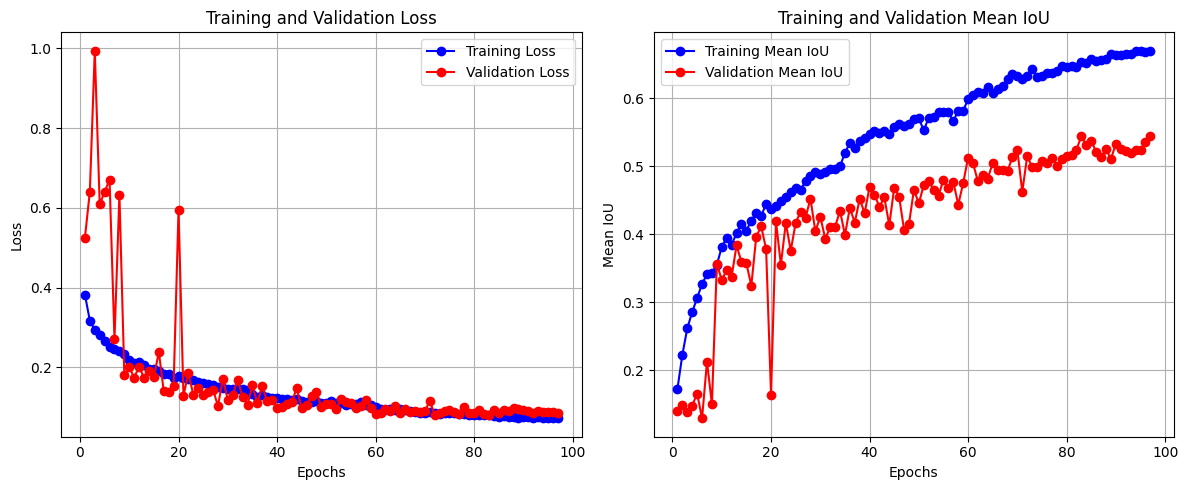

In [14]:
# Extract values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mean_iou = history.history['final_output_mean__io_u']
val_mean_iou = history.history['val_final_output_mean__io_u']

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Mean IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, train_mean_iou, 'bo-', label='Training Mean IoU')
plt.plot(epochs, val_mean_iou, 'ro-', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation

In [15]:
results = model.evaluate(valid_dataset, verbose=1)
print('validation loss:', results[0])
print('validation IoU:', results[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - final_output_mean__io_u: 0.5032 - loss: 0.0803 - output_1_mean__io_u: 0.5029 - output_2_mean__io_u: 0.5048 - output_3_mean__io_u: 0.5119
validation loss: 0.07974158227443695
validation IoU: 0.5148720741271973


## Post processing

The apply_morphology(mask) function applies morphological operations to a multi-class mask.
 - Opening: Removes small, isolated regions of any class by eroding and then dilating the mask.
 - Closing: Fills small gaps or holes in the detected regions by dilating and then eroding the mask.

These operations help refine the mask by removing noise and closing gaps, improving segmentation accuracy and overall model performance.

In [16]:
def apply_morphology(mask):
    kernel = np.ones((3,3), np.uint8)
    # Opening to remove small objects
    mask_clean = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    # Closing to fill small holes
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)
    return mask_clean

Confusion Matrix:
[[343210 182170 133280  85396   6094]
 [ 37739 951750  32218  18664   1279]
 [ 56868  34536 597018   2915   1448]
 [ 66762   6366  20528 498705     38]
 [   910     19    490     68   1721]]


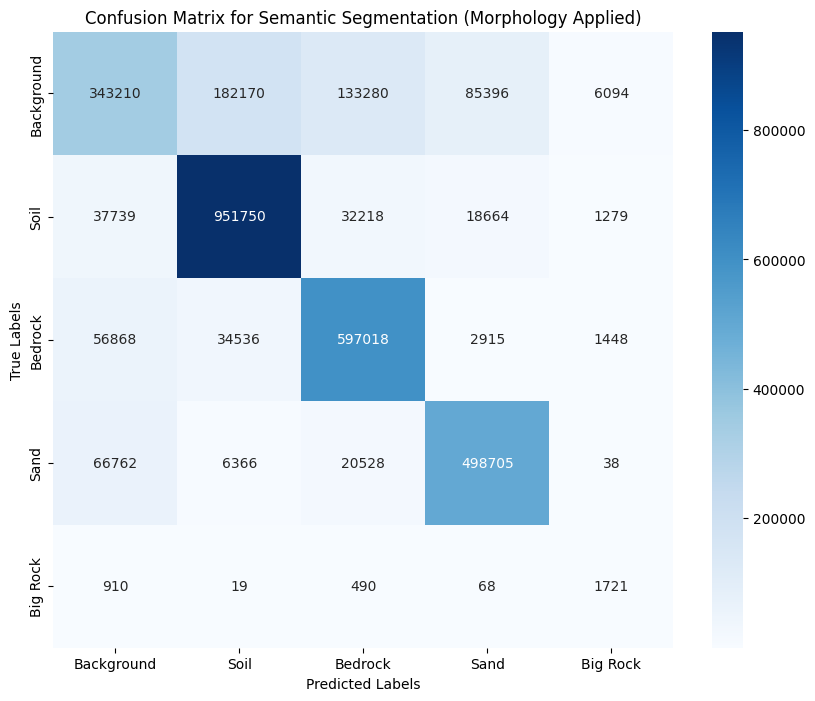

Classification Report:
              precision    recall  f1-score   support

  Background       0.68      0.46      0.55    750150
        Soil       0.81      0.91      0.86   1041650
     Bedrock       0.76      0.86      0.81    692785
        Sand       0.82      0.84      0.83    592399
    Big Rock       0.16      0.54      0.25      3208

    accuracy                           0.78   3080192
   macro avg       0.65      0.72      0.66   3080192
weighted avg       0.77      0.78      0.77   3080192

Mean IoU value calculated manually: 0.53265375


In [17]:
class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']

def compute_confusion_matrix_and_classification_report(model, valid_dataset, apply_morph_flag):
    y_true = []
    y_pred = []
    num_batches = len(valid_dataset)
    
    for i in range(num_batches):
        batch_x, batch_y = valid_dataset[i]
        preds = model.predict(batch_x, verbose=0)
        final_preds = preds[-1]
        
        for b in range(final_preds.shape[0]):
            probs = final_preds[b]  # (H,W,C)
            true_mask = batch_y['final_output'][b]  # (H,W)
            refined_mask = np.argmax(probs, axis=-1)  # (H,W)
            
            # Apply morphological operation if requested
            if apply_morph_flag:
                refined_mask = apply_morphology(refined_mask)
            
            y_true.extend(true_mask.flatten())
            y_pred.extend(refined_mask.flatten())
    
    # Convert lists to tensors for mean IoU
    y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.int32)
    y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.int32)
    
    # Compute Mean IoU using TensorFlow's built-in function
    num_classes = len(class_names)
    m = tf.keras.metrics.MeanIoU(num_classes=num_classes)
    m.update_state(y_true_tensor, y_pred_tensor)
    mean_iou_value = m.result().numpy()
    
    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    
    # Compute Classification Report
    class_report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    
    return cm, class_report, mean_iou_value

# Example usage:
cm, class_report, mean_iou_value = compute_confusion_matrix_and_classification_report(
    model, 
    valid_dataset,
    apply_morph_flag=True
)

print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Semantic Segmentation (Morphology Applied)')
plt.show()

print("Classification Report:")
print(class_report)

print('Mean IoU value calculated manually:', mean_iou_value)

## Saving Predictions for final submission on Kaggle

In [18]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_241214_170312.keras


In [19]:
loaded_model = tf.keras.models.load_model(
    model_filename, 
    custom_objects={'mean_IoU': mean_IoU, 'focal_loss_fixed': focal_loss}
)
print(f"Model loaded from {model_filename}")

Model loaded from model_241214_170312.keras


In [20]:
X_test = np.expand_dims(test, axis=-1)
X_test = X_test.astype(np.float32) / 255.0

preds = loaded_model.predict(X_test)[-1]
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 37s 113ms/step
Predictions shape: (10022, 64, 128)


### Apply Post processing

In [21]:
for i in range(preds.shape[0]):
    preds[i] = apply_morphology(preds[i])
print(f"Predictions shape: {preds.shape}")

Predictions shape: (10022, 64, 128)


### Creating final file for submission

This piece of code converts the output of the model with the format specified on the competition website.

In [22]:
import zipfile

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
zip_filename = submission_filename.replace(".csv", ".zip")
submission_df = y_to_df(preds)
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    with zipf.open(submission_filename, 'w') as csvfile:
        csvfile.write(submission_df.to_csv(index=False).encode('utf-8'))

print(f"ZIP file created: {zip_filename}")

ZIP file created: submission_241214_170312.zip
